In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql import functions as F

In [37]:
reviewers = spark.read.json('gs://big-data-final-project-260317.appspot.com/reviews_Books_5.json')

In [38]:
reviewers = reviewers.drop('helpful', 'unixReviewTime')

In [39]:
reviewers = reviewers.na.drop(subset = ['asin', 'overall', 'reviewText','reviewTime', 'reviewerID', 'summary'])

In [10]:
reviewers.show()

+----------+-------+--------------------+-----------+--------------------+--------------------+--------------------+
|      asin|overall|          reviewText| reviewTime|          reviewerID|        reviewerName|             summary|
+----------+-------+--------------------+-----------+--------------------+--------------------+--------------------+
|000100039X|    5.0|Spiritually and m...|12 16, 2012|A10000012B7CGYKOM...|                Adam|          Wonderful!|
|000100039X|    5.0|This is one my mu...|12 11, 2003|      A2S166WSCFIFP5|adead_poet@hotmai...|        close to god|
|000100039X|    5.0|This book provide...|01 18, 2014|      A1BM81XB4QHOA3|Ahoro Blethends "...|Must Read for Lif...|
|000100039X|    5.0|I first read THE ...|09 27, 2011|      A1MOSTXNIO5MPJ|           Alan Krug|Timeless for ever...|
|000100039X|    5.0|A timeless classi...| 10 7, 2002|      A2XQ5LZHTD4AFT|            Alaturka|       A Modern Rumi|
|000100039X|    5.0|Reading this made...|01 27, 2014|      A3V1M

In [40]:
description = spark.read.json('gs://big-data-final-project-260317.appspot.com/metaBooks.json')

In [41]:
description = description.drop('brand', 'categories')

In [42]:
description = description.na.drop(subset = ['asin', 'description', 'price', 'salesRank', 'title'])

In [17]:
description.show()

+----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|      asin|         description|               imUrl|price|             related|           salesRank|               title|
+----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|0001048236|&#34;One thing is...|http://ecx.images...| 9.26|[, [1442300191, 9...|[, 8973864,,,,,,,...|The Sherlock Holm...|
|0001053396|Writing poetry ha...|http://ecx.images...|17.99|                null|[, 12249714,,,,,,...|War Poems: An Ant...|
|0001053744|While many reader...|http://ecx.images...| 6.05|[, [0345277600],,...|[, 5665835,,,,,,,...| Pearl and Sir Orfeo|
|0001055178|Beryl Bainbridge ...|http://ecx.images...|16.95|[, [0349116156, 0...|[, 14149327,,,,,,...|      Master Georgie|
|0001360000|Judith Kerr&#8217...|http://ecx.images...|10.76|[[0007171285, 000...|[, 1760368,,,,,,,...|       Mog's Kittens|
|0001018

###   - Distribution of books with different overall ratings

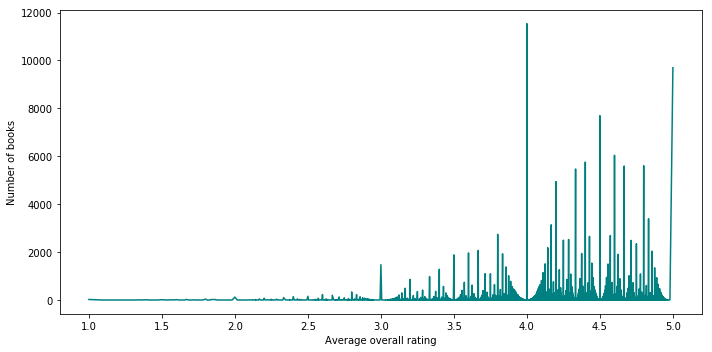

In [30]:

rating = reviewers.groupBy("asin").agg(F.mean("overall")) # this will merge the same asin's and have an average overall rating for them
ratingSalesRank = rating.join(description, ['asin'])
ratingSales = ratingSalesRank.select(F.col('avg(overall)').alias('Ratings'), 'asin').sort(F.desc('avg(overall)'))
# ratingSales.show()
ratingSales.createOrReplaceTempView('ratings')
sqlRatingBooks = spark.sql("SELECT Ratings, COUNT(*) AS NumberBooks FROM ratings GROUP BY Ratings ORDER BY Ratings DESC")
# sqlRatingBooks.show()

RatingBooksPd = sqlRatingBooks.toPandas()
plt.figure(figsize=(10,5))
plt.plot(RatingBooksPd['Ratings'], RatingBooksPd['NumberBooks'], color='teal')
plt.xlabel('Average overall rating')
plt.ylabel('Number of books')
plt.tight_layout()
plt.show()

 ### - Average ratings for books as a function of salesRank

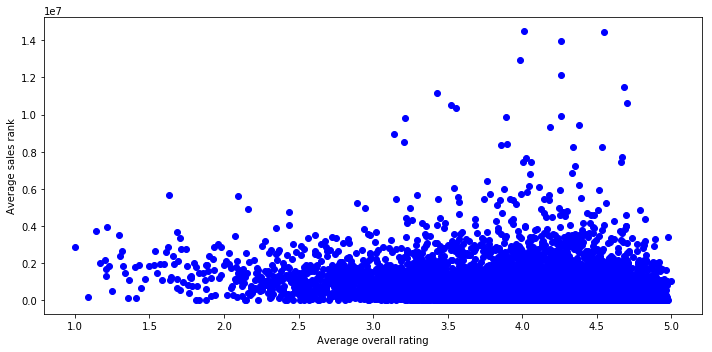

In [31]:

rating = reviewers.groupBy("asin").agg(F.mean("overall"))
# rating.show()
ratingSalesRank = rating.join(description, ['asin'])
ratingSales = ratingSalesRank.select('avg(overall)', ratingSalesRank.salesRank.Books.alias('sales_rank')).sort(F.desc('avg(overall)'))
# ratingSales.show()

### average salesRank for a overall review ####
ratingSales = ratingSales.groupBy('avg(overall)').agg(F.mean('sales_rank')).sort(F.desc('avg(overall)')) # this will calculate an average sales rank for the books with same overall ratings
# ratingSales.show()

### converting to pandas df and plotting
ratingSalesPd = ratingSales.toPandas()
plt.figure(figsize=(10,5))
plt.scatter(ratingSalesPd['avg(overall)'], ratingSalesPd['avg(sales_rank)'], color='blue')
plt.xlabel('Average overall rating')
plt.ylabel('Average sales rank')
plt.tight_layout()
plt.show()

### - Book reviews by prolific reviewers (reviewers who have 10 or more reviews) 

In [43]:

reviewers.createOrReplaceTempView('reviews')
sqlTextReview = spark.sql("SELECT reviewerID FROM reviews GROUP BY reviewerID HAVING COUNT(reviewerID) > 10")
# print(sqlTextReview.count())
# sqlTextReview.show()
prolificReviewers = sqlTextReview.join(reviewers, sqlTextReview.reviewerID == reviewers.reviewerID)
# print(prolificReviewers.count())
reviewsDetails = prolificReviewers.join(description, ['asin'])
reviewsDetails = reviewsDetails.select('asin', 'title', 'reviewText', 'summary')
reviewsDetails.show()

+----------+-------------------+--------------------+--------------------+
|      asin|              title|          reviewText|             summary|
+----------+-------------------+--------------------+--------------------+
|0006476155|Along Came a Spider|ALONG CAME A SPID...|It was well done,...|
|0006476155|Along Came a Spider|From one of the g...|And along came Ja...|
|0006476155|Along Came a Spider|This is the first...|A great psycholog...|
|0006476155|Along Came a Spider|James Patterson d...| Along Came a Spider|
|0006476155|Along Came a Spider|I picked up Along...|Silence of the La...|
|0006476155|Along Came a Spider|Patterson is a ef...|           Good Book|
|0006476155|Along Came a Spider|ALONG CAME A SPID...|Another Winner fo...|
|0006476155|Along Came a Spider|I read this book ...|Good  suspense, b...|
|0006476155|Along Came a Spider|1) Plot (5 stars)...|Plot - 5, Charact...|
|0006476155|Along Came a Spider|Amazing page turn...|             Awesome|
|0006476155|Along Came a 

### - Distribution of number of reviews by prolific reviewers (who have > 10 reviews) 

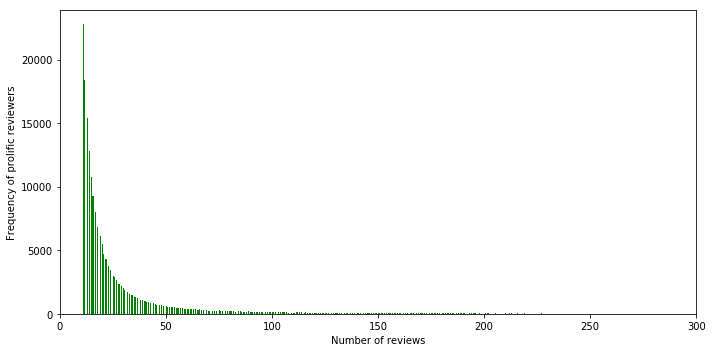

In [44]:

reviewers.createOrReplaceTempView('reviews')
sqlReview = spark.sql("SELECT reviewerID, COUNT(reviewerID) FROM reviews GROUP BY reviewerID HAVING COUNT(reviewerID) > 10")
# print(sqlReview.count())

sqlReview = sqlReview.sort(F.desc('count(reviewerID)'))
# sqlReview.select([F.mean('COUNT(reviewerID)'), F.min('COUNT(reviewerID)'), F.max('COUNT(reviewerID)')]).show()
# sqlReview.show() #number of reviews by a reviewer

reviews_prolificPandas = sqlReview.toPandas()
# plot for number of reviewers who have given the number of reviews on X axis
plt.figure(figsize=(10,5))
plt.hist(reviews_prolificPandas['count(reviewerID)'], color='green', bins='auto')
plt.xlabel('Number of reviews')
plt.ylabel('Frequency of prolific reviewers')
plt.xlim(0,300)
plt.tight_layout()
plt.show()

### - Trends in reviews as a function of years/months 

In [52]:
# retrieve the years from reviewTime column
split_col = F.split(reviewers.reviewTime, ',')
review_years = reviewers.withColumn('years', split_col.getItem(1))

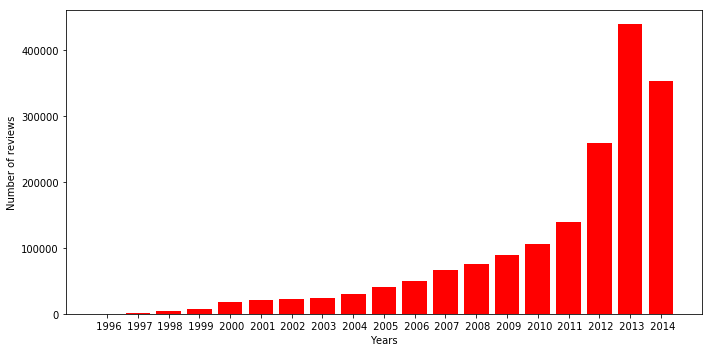

In [53]:
yearlyReviews = review_years.groupBy("years").agg(F.countDistinct("reviewerID")).sort(F.asc("years"))
# yearlyReviews.show()
yearlyPandas = yearlyReviews.toPandas()

plt.figure(figsize=(10,5))
plt.bar(yearlyPandas['years'], yearlyPandas['count(DISTINCT reviewerID)'], color='red')
plt.xlabel('Years')
plt.ylabel('Number of reviews')
plt.tight_layout()
plt.show()

### - Correlation between number of reviews and price

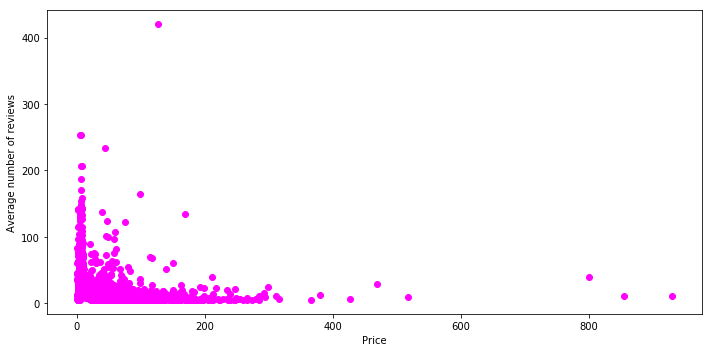

In [54]:
sqlNumReviews = reviewers
totalReviews = sqlNumReviews.groupBy("asin").agg(F.countDistinct("reviewerID"))
# totalReviews.show()
reviewsAndPrice = totalReviews.join(description, totalReviews.asin == description.asin)
# print(totalReviews.count(), reviewsAndPrice.count())
reviewsAndPrice = reviewsAndPrice.select('count(DISTINCT reviewerID)', 'price')

### average number of reviews for a price ###
reviewsAndPrice = reviewsAndPrice.groupBy('price').agg(F.mean('count(DISTINCT reviewerID)')).sort(F.asc('price'))
# reviewsAndPrice.show()

### converting to pandas df and plotting ###
reviewsPricePd = reviewsAndPrice.toPandas()
plt.figure(figsize=(10,5))
plt.scatter(reviewsPricePd['price'], reviewsPricePd['avg(count(DISTINCT reviewerID))'], color = 'magenta')
plt.xlabel('Price')
plt.ylabel('Average number of reviews')
plt.tight_layout()
plt.show()